# Examples

```
date: 2025-01-15
authors:
    - name: Brookie Guzder-Williams
affiliations:
    - University of California Berkeley, The Eric and Wendy Schmidt Center for Data Science & Environment
license: CC-BY-4.0
```

This notebook gives examples of how to use DSE's [Spectral Trend Database](https://github.com/SchmidtDSE/spectral_trend_database).  In particular we look at:

1. Querying the Database
2. Parsing the data
3. Visualizing the data


---

### IMPORTS


In [1]:
from pprint import pprint
import matplotlib.pyplot as plt
from google.cloud import bigquery as bq
from spectral_trend_database.config import config as c
from spectral_trend_database import query
from spectral_trend_database import utils


---

### CONFIG

In [2]:
BQ_PREFIX = 'dse-regenag.SpectralTrendDatabase'
SAMPLE_FRAC = 0.0005
YEAR_START = 2008
YEAR_END = 2020
START_MMDD = '11-01'
END_MMDD = START_MMDD
ATTR_COLS = [
    'sample_id',
    'lon',
    'lat']
LIST_ATTRS = [
    'year',
    'biomass',
    'crop_type']
CHART_DATA_PATH = 'spectral_trends.chart_data.json'


---

### HELPER METHODS


In [3]:
def print_list(lst, max_len=7, view_size=3, sep=', ', connector=' ... '):
    size = len(lst)
    if size <= max_len:
        lst_str = sep.join(lst)
    else:
        head = sep.join(lst[:view_size])        
        tail = sep.join(lst[-view_size:])
        lst_str = f'{head}{connector}{tail}  [{size}]'
    print(lst_str)

def line(marker='-', length=100):
    print(marker*length)

## DATABSE QUERIES

---

### STDB DATABASE INFO

First we'll take a quick peak at the what is in the STDB database

In [4]:
SAMPLES_TABLE = 'SAMPLE_POINTS'
YIELD_TABLE = 'QDANN_YIELD'
SMOOTHED_INDICES_TABLE = 'SMOOTHED_INDICES_V1'
IDENT_DATE_COLUMNS = ['sample_id', 'year', 'date']

In [5]:
COLUMN_NAMES = {}
print('DATABASE INFO')
line()
table_names = query.table_names()
print('TABLES:')
pprint(table_names)
for table_name in [SAMPLES_TABLE, YIELD_TABLE, SMOOTHED_INDICES_TABLE]:
    COLUMN_NAMES[table_name] = query.column_names(table_name, run_query=True)
    print(f'\n{table_name}:')
    print_list(COLUMN_NAMES[table_name])
line()

DATABASE INFO
----------------------------------------------------------------------------------------------------
TABLES:
['QDANN_YIELD',
 'SMOOTHED_INDICES_V1',
 'INDICES_STATS_V1',
 'RAW_INDICES_V1',
 'SAMPLE_POINTS',
 'CDL_CROP_TYPE',
 'MACD_INDICES_V1']

SAMPLE_POINTS:
AWATER, ALAND, LSAD ... h3_4, NAME, h3_9  [20]

QDANN_YIELD:
nb_years, biomass, year, sample_id

SMOOTHED_INDICES_V1:
si1, rvi, si ... savi, rdvi, year  [45]
----------------------------------------------------------------------------------------------------


In [6]:
INDICES = [c for c in COLUMN_NAMES[SMOOTHED_INDICES_TABLE] if c not in IDENT_DATE_COLUMNS]
print_list(INDICES)

si1, rvi, si ... blue, savi, rdvi  [42]



---

### USING BIG QUERY

The data is in a big-query database, and so can be accessed using the big-query api

In [7]:
#| label: nb.example_query_bq

client = bq.Client()
sql = f'SELECT sample_id, date, ndvi FROM `{BQ_PREFIX}.RAW_INDICES_V1` LIMIT 3'
resp = client.query(sql)
resp.to_dataframe()

,sample_id,date,ndvi
0,dp763hn7zdm,2005-05-27,0.257654
1,dp763hn7zdm,2005-04-09,0.195065
2,dp763hn7zdm,2005-03-16,0.018234



---

### QueryConstructor and Helper Methods

Using big-query directly is easy enough.  However, constructing SQL statements with lots of `JOIN` and `WHERE` statements can be painful.  To handle this we've developed a simple QueryConstructor. Additionaly we've added a few convience methods 
so the user never needs to use the big-query python module directly.  You've already seen two of them: `query.table_names` and `query.column_names`.

Let's start by reproducing the SQL in our simple example above

In [8]:
#| label: nb.example_query_stdb_basic

qc = query.QueryConstructor('RAW_INDICES_V1', table_prefix=BQ_PREFIX)
qc.select('sample_id', 'date', 'ndvi')
qc.limit(3)
df = query.run(sql=qc.sql())

print(qc.sql(),'\n')
df

SELECT sample_id, date, ndvi FROM `dse-regenag.SpectralTrendDatabase.RAW_INDICES_V1` LIMIT 3 



,sample_id,date,ndvi
0,dp763hn7zdm,2005-05-27,0.257654
1,dp763hn7zdm,2005-04-09,0.195065
2,dp763hn7zdm,2005-03-16,0.018234


Now we'll create an more complicated request using the sample_ids  from the above example.

First I'll need to select the sample_ids of interest

In [9]:
qc = query.QueryConstructor('SAMPLE_POINTS', table_prefix=BQ_PREFIX)
qc.select('DISTINCT sample_id')
qc.limit(3)
qc.sql()

'SELECT DISTINCT sample_id FROM `dse-regenag.SpectralTrendDatabase.SAMPLE_POINTS` LIMIT 3'

In [10]:
locales_df = query.run(sql=qc.sql())
sample_ids = locales_df.sample_id.tolist()
sample_ids

['9yrxd2cmudy', '9yry7n3rvb5', '9yryeyjyhre']

In [25]:
#| label: nb.example_query_stdb_advanced

qc = query.QueryConstructor(
        'SAMPLE_POINTS', 
        table_prefix=BQ_PREFIX,
        using=['sample_id'],  
        how='inner')
qc.join('MACD_INDICES_V1')
qc.join('SMOOTHED_INDICES_V1', 'sample_id', 'date')
qc.where_in(sample_id=sample_ids)
qc.where('SMOOTHED_INDICES_V1', year=2010, year_op='>=')
qc.where('SMOOTHED_INDICES_V1', year=2014, year_op='<')
qc.orderby('date', table='MACD_INDICES_V1')
df = query.run(sql=qc.sql(), print_sql=True)
example_id = df.sample_id.sample().iloc[0]
rows = df[df.sample_id == example_id]
rows

[info] spectral_trend_database.query.run: SELECT * FROM `dse-regenag.SpectralTrendDatabase.SAMPLE_POINTS` INNER JOIN `dse-regenag.SpectralTrendDatabase.MACD_INDICES_V1` USING (sample_id) INNER JOIN `dse-regenag.SpectralTrendDatabase.SMOOTHED_INDICES_V1` USING (sample_id, date) WHERE `dse-regenag.SpectralTrendDatabase.SAMPLE_POINTS`.sample_id IN ('9yrxd2cmudy', '9yry7n3rvb5', '9yryeyjyhre') AND `dse-regenag.SpectralTrendDatabase.SMOOTHED_INDICES_V1`.year >= 2010 AND `dse-regenag.SpectralTrendDatabase.SMOOTHED_INDICES_V1`.year < 2014 ORDER BY `dse-regenag.SpectralTrendDatabase.MACD_INDICES_V1`.date ASC


,sample_id,date,AWATER,ALAND,LSAD,STATE_NAME,STUSPS,GEOID,GEOIDFQ,NAMELSAD,...,nli,nir,red,evi2,rdi,gli,blue,savi,rdvi,year_1
2,9yryeyjyhre,2010-01-01,5497697,1655581941,6,Arkansas,AR,5021,0500000US05021,Clay County,...,-0.572802,0.183808,0.124341,0.109055,0.940264,-0.017634,0.069114,0.110383,0.107393,2010
4,9yryeyjyhre,2010-01-02,5497697,1655581941,6,Arkansas,AR,5021,0500000US05021,Clay County,...,-0.572218,0.184255,0.124729,0.109094,0.938990,-0.017667,0.069355,0.110379,0.107357,2010
6,9yryeyjyhre,2010-01-03,5497697,1655581941,6,Arkansas,AR,5021,0500000US05021,Clay County,...,-0.571634,0.184701,0.125116,0.109132,0.937715,-0.017699,0.069597,0.110375,0.107320,2010
9,9yryeyjyhre,2010-01-04,5497697,1655581941,6,Arkansas,AR,5021,0500000US05021,Clay County,...,-0.571051,0.185148,0.125504,0.109171,0.936441,-0.017732,0.069838,0.110371,0.107284,2010
14,9yryeyjyhre,2010-01-05,5497697,1655581941,6,Arkansas,AR,5021,0500000US05021,Clay County,...,-0.570467,0.185595,0.125892,0.109209,0.935166,-0.017765,0.070079,0.110367,0.107248,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4382,9yryeyjyhre,2013-12-27,5497697,1655581941,6,Arkansas,AR,5021,0500000US05021,Clay County,...,-0.202291,0.242433,0.088612,0.277151,0.456971,0.101459,0.048870,0.277339,0.267046,2013
4384,9yryeyjyhre,2013-12-28,5497697,1655581941,6,Arkansas,AR,5021,0500000US05021,Clay County,...,-0.195865,0.243806,0.088405,0.279786,0.454575,0.102925,0.048268,0.279847,0.269378,2013
4388,9yryeyjyhre,2013-12-29,5497697,1655581941,6,Arkansas,AR,5021,0500000US05021,Clay County,...,-0.189850,0.245132,0.088244,0.282250,0.452865,0.104134,0.047707,0.282184,0.271544,2013
4391,9yryeyjyhre,2013-12-30,5497697,1655581941,6,Arkansas,AR,5021,0500000US05021,Clay County,...,-0.184250,0.246409,0.088127,0.284544,0.451817,0.105088,0.047191,0.284349,0.273544,2013


# PARSING THE DATA

---


We can easily turn these rows into xarray-datasets to more easily parse interact with the data.   

<xarray.Dataset>
Dimensions:        (date: 1465)
Coordinates:
  * date           (date) datetime64[ns] 2010-01-01 2010-01-02 ... 2013-12-31
Data variables: (12/59)
    ndvi_macd_div  (date) float64 6.266e-06 2.323e-05 ... -0.0008927 -0.0009614
    evi2_macd      (date) float64 3.078e-05 3.904e-05 ... 0.007764 0.007463
    ndvi_macd      (date) float64 -0.001 -0.0009719 -0.0009457 ... 0.01055 0.01
    evi2_ema_c     (date) float64 4.309e-05 4.174e-05 ... 0.008226 0.007972
    ndvi_ema_c     (date) float64 -0.001007 -0.0009951 ... 0.01144 0.01096
    evi2_ema_b     (date) float64 0.109 0.109 0.109 ... 0.2687 0.2716 0.2743
    ...             ...
    rdi            (date) float64 0.9403 0.939 0.9377 ... 0.4529 0.4518 0.4514
    gli            (date) float64 -0.01763 -0.01767 -0.0177 ... 0.1051 0.1058
    blue           (date) float64 0.06911 0.06936 0.0696 ... 0.04719 0.04672
    savi           (date) float64 0.1104 0.1104 0.1104 ... 0.2822 0.2843 0.2863
    rdvi           (date) float64 0.1074 0.1074 0.1073 ... 0.2715 0.2735 0.2754
    year_1         (date) int64 2010 2010 2010 2010 2010 ... 2013 2013 2013 2013
Attributes: (12/20)
    AWATER:      5497697
    ALAND:       1655581941
    LSAD:        6
    STATE_NAME:  Arkansas
    STUSPS:      AR
    GEOID:       5021
    ...          ...
    sample_id:   9yryeyjyhre
    COUNTYNS:    63759
    lat:         36.3328579428
    h3_4:        84265d1ffffffff
    NAME:        Clay
    h3_9:        89265d10cc3ffff

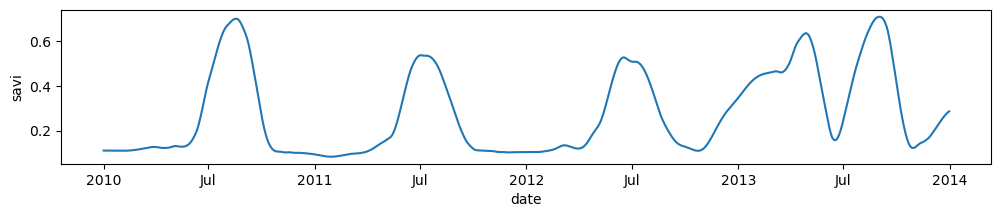

In [26]:
ATTR_COLS = COLUMN_NAMES[SAMPLES_TABLE]
ds = utils.rows_to_xr(rows, attr_cols=ATTR_COLS)
fig, ax = plt.subplots(figsize=(12, 2))
ds.savi.plot(ax=ax)
display(ds)

xarrays can easily be filtered by dates

<xarray.Dataset>
Dimensions:        (date: 198)
Coordinates:
  * date           (date) datetime64[ns] 2012-04-01 2012-04-02 ... 2012-10-15
Data variables: (12/59)
    ndvi_macd_div  (date) float64 0.0005558 0.0006669 ... 3.471e-05 4.731e-05
    evi2_macd      (date) float64 -0.0006321 -0.0004123 ... -0.002915 -0.00288
    ndvi_macd      (date) float64 -0.003304 -0.00286 ... -0.00209 -0.002054
    evi2_ema_c     (date) float64 -0.0009047 -0.0007406 ... -0.002943 -0.002922
    ndvi_ema_c     (date) float64 -0.00386 -0.003527 ... -0.002125 -0.002101
    evi2_ema_b     (date) float64 0.1266 0.1266 0.1267 ... 0.1205 0.1194 0.1182
    ...             ...
    rdi            (date) float64 1.154 1.162 1.168 1.173 ... 1.045 1.045 1.045
    gli            (date) float64 0.004976 0.005649 ... -0.0225 -0.02324
    blue           (date) float64 0.1142 0.115 0.1156 ... 0.06677 0.0665 0.06623
    savi           (date) float64 0.1196 0.12 0.1206 ... 0.1156 0.1147 0.1138
    rdvi           (date) float64 0.1135 0.1139 0.1144 ... 0.1119 0.1111 0.1103
    year_1         (date) int64 2012 2012 2012 2012 2012 ... 2012 2012 2012 2012
Attributes: (12/20)
    AWATER:      5497697
    ALAND:       1655581941
    LSAD:        6
    STATE_NAME:  Arkansas
    STUSPS:      AR
    GEOID:       5021
    ...          ...
    sample_id:   9yryeyjyhre
    COUNTYNS:    63759
    lat:         36.3328579428
    h3_4:        84265d1ffffffff
    NAME:        Clay
    h3_9:        89265d10cc3ffff

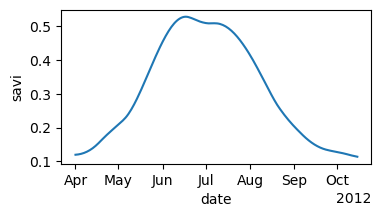

In [27]:
#| label: nb.filter_by_dates

START_MMDD = '04-01'
END_MMDD = '10-15'

def growing_season_for_year(ds, year):
    return ds.sel(dict(date=slice(f'{year}-{START_MMDD}', f'{year}-{END_MMDD}')))

_ds = growing_season_for_year(ds, 2012)
fig, ax = plt.subplots(figsize=(4, 2))
_ds.savi.plot(ax=ax)
display(_ds)


---

## Computations and Visulaizations


In [28]:
SUPTITLE = 'Spectral Trends'
TITLE = 'Exponentially Weighted Moving Average and NDVI versus NDWI'
SUPTITLE_FONT_SIZE = 22
SUPTITLE_CLR = '#555'
TITLE_FONT_SIZE = 14
TITLE_CLR = '#999'
LABEL_FONT_SIZE = 16
LABEL_CLR = '#333'

In [29]:
def twinx_legend(ax, ax2):
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    return ax2.legend(lines + lines2, labels + labels2, loc=0)

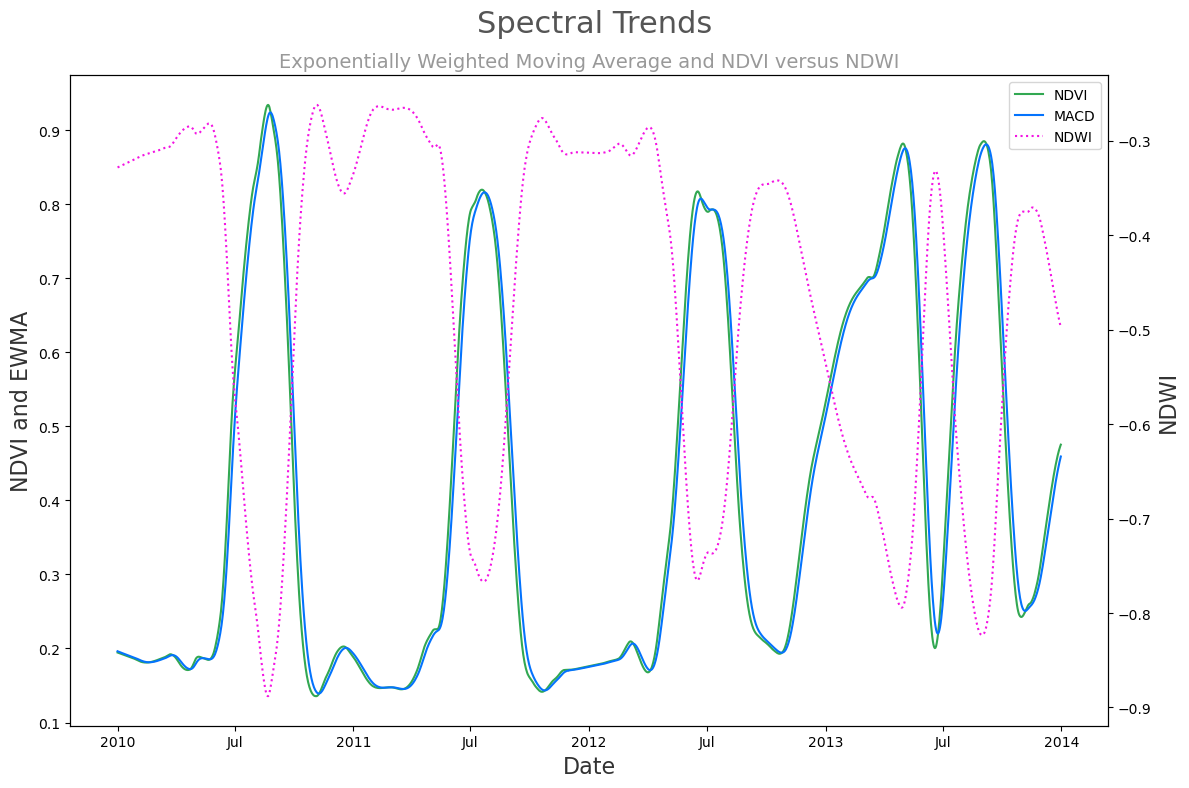

In [30]:
#| label: nb.ndvi_vs_ema

fig, ax = plt.subplots(figsize=(12, 8))
ax2 = ax.twinx()

ds.ndvi.plot(color='#32a852', label='NDVI', ax=ax)
ds.ndvi_ema_b.plot(color='#0473fd', label='MACD', ax=ax)
ds.ndwi.plot(color='#f413e3', linestyle='dotted', label='NDWI', ax=ax2)

plt.title(TITLE,fontsize=TITLE_FONT_SIZE,color=TITLE_CLR)
plt.suptitle(SUPTITLE,fontsize=SUPTITLE_FONT_SIZE,color=SUPTITLE_CLR)

ax.set_ylabel('NDVI and EWMA', fontsize=LABEL_FONT_SIZE, color=LABEL_CLR)
ax2.set_ylabel('NDWI', fontsize=LABEL_FONT_SIZE, color=LABEL_CLR)
ax.set_xlabel('Date', fontsize=LABEL_FONT_SIZE, color=LABEL_CLR)
twinx_legend(ax, ax2)

plt.tight_layout()